In [1]:
from transformer_lens.hook_points import HookedRootModule, HookPoint

In [2]:
import torch
from transformers import AutoTokenizer, AutoModel
import TransformerLens.transformer_lens.utils as utils
import numpy as np
from sentence_transformers import CrossEncoder
from TransformerLens.transformer_lens import HookedEncoder
from patching_helpers import (
    get_act_patch_block_every,
    get_act_patch_attn_head_out_all_pos,
    get_act_patch_attn_head_by_pos,
    get_path_patch_head_to_final_resid_post,
    get_path_patch_head_to_heads
)

def load_tokenizer_and_models(hf_model_name, device):
    cross_encoder_model = CrossEncoder(hf_model_name).model
    tokenizer = AutoTokenizer.from_pretrained(hf_model_name)
    hf_model = AutoModel.from_pretrained(hf_model_name)
    hf_model.to(device)
    pooler_layer = hf_model.pooler.to(device)
    dropout_layer = cross_encoder_model.dropout.to(device)
    classifier_layer = cross_encoder_model.classifier.to(device)
    tl_model = HookedEncoder.from_pretrained(hf_model_name, device=device, hf_model=hf_model)
    return tokenizer, tl_model, pooler_layer,dropout_layer,classifier_layer


In [3]:
torch.set_grad_enabled(False)
device = utils.get_device()

# Load and initialize models
pre_trained_model_name = "cross-encoder/ms-marco-MiniLM-L-12-v2" #"sebastian-hofstaetter/distilbert-dot-tas_b-b256-msmarco"
tokenizer, tl_model, pooler_layer,dropout_layer,classifier_layer = load_tokenizer_and_models(pre_trained_model_name, device)

mps.is_available()


/Users/meng.lu/miniforge3/envs/tensor_env/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
If using BERT for interpretability research, keep in mind that BERT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


will start convert_hf_model_config
Moving model to device:  mps
Loaded pretrained model cross-encoder/ms-marco-MiniLM-L-12-v2 into HookedEncoder


In [4]:

# Minimal usage example 
query = "what is the acceptance rate at wellesley"
original_doc = "College acceptance rates in the USA are becoming more competitive."
perturbed_doc = original_doc + " " + "wellesley"

# Tokenize query and documents, adjusting for mismatched lengths if necessary
tokenized_pair_baseline = tokenizer([query],[original_doc], return_tensors="pt",padding=True,truncation=True)
tokenized_pair_perturbed = tokenizer([query],[perturbed_doc], return_tensors="pt",padding=True, truncation=True)
print(tokenized_pair_baseline)
print(tokenized_pair_perturbed)

cls_tok = tokenized_pair_baseline["input_ids"][0][0]
sep_tok = tokenized_pair_baseline["input_ids"][0][-1]
print(f"cls_tok: {cls_tok}")
print(f"sep_tok: {sep_tok}")

filler_token = tokenizer.encode("a", add_special_tokens=False)[0]
b_len = torch.sum(tokenized_pair_baseline["attention_mask"]).item()
p_len = torch.sum(tokenized_pair_perturbed["attention_mask"]).item()

if b_len != p_len: #TODO: need to edit
    print("b_len != p_len")
    adj_n = p_len - b_len
    filler_tokens = torch.full((adj_n,), filler_token)
    filler_attn_mask = torch.full((adj_n,), tokenized_pair_baseline["attention_mask"][0][1]) 
    filler_token_id_mask = torch.full((adj_n,), tokenized_pair_baseline["token_type_ids"][0][-1]) #just filling in the document
    adj_doc = torch.cat((tokenized_pair_baseline["input_ids"][0][1:-1], filler_tokens))
    tokenized_pair_baseline["input_ids"] = torch.cat((cls_tok.view(1), adj_doc, sep_tok.view(1)), dim=0).view(1,-1)
    tokenized_pair_baseline["attention_mask"] = torch.cat((tokenized_pair_baseline["attention_mask"][0], filler_attn_mask), dim=0).view(1,-1)
    tokenized_pair_baseline["token_type_ids"] = torch.cat((tokenized_pair_baseline["token_type_ids"][0], filler_token_id_mask), dim=0).view(1,-1)

    #inputs <cls> query <sep> document <sep>
    #if edited in this block, print out the renewed ones:
    print(f"tokenized_pair_baseline: {tokenized_pair_baseline}")
    print(f"tokenized_pair_perturbed: {tokenized_pair_perturbed}")


{'input_ids': tensor([[  101,  2054,  2003,  1996,  9920,  3446,  2012, 25658,   102,  2267,
          9920,  6165,  1999,  1996,  3915,  2024,  3352,  2062,  6975,  1012,
           102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
{'input_ids': tensor([[  101,  2054,  2003,  1996,  9920,  3446,  2012, 25658,   102,  2267,
          9920,  6165,  1999,  1996,  3915,  2024,  3352,  2062,  6975,  1012,
         25658,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
cls_tok: 101
sep_tok: 102
b_len != p_len
tokenized_pair_baseline: {'input_ids': tensor([[  101,  2054,  2003,  1996,  9920,  3446,  2012, 25658,   102,  2267,
          9920,  6165,  1999,  1996,  3915,  2024,  3352,  2062,  6975,  1

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Plotting Functions
def plot_heatmap_block(data, labels):
    print(data.shape) #(3, 12, 22) #12 layers, 22 labels
    blocks = ["resid_pre", "attn_out", "mlp_out"]
    for i in range(3):
        title = blocks[i]
        plot_data = data[i,:,:].squeeze() #(12,22)
        plot_data = np.flipud(plot_data)
        plt.figure(figsize=(12, 6))
        sns.heatmap(plot_data, xticklabels=labels, yticklabels=range(11,-1,-1), cmap='viridis', cbar=True,vmin=0.0, vmax=1.0)
        #!!!FILP yticklabels and FLIP the data on y axis
        plt.title(title)
        plt.xlabel('posn')
        plt.ylabel('Layers')
        plt.show()
def plot_heatmap_attention(data, labels):
    print(data.shape) #(12,12) layer head
    data = np.flipud(data)
    plt.figure(figsize=(8, 6))
    sns.heatmap(data, xticklabels=range(0,12), yticklabels=range(11,-1,-1), cmap='viridis', cbar=True)
    #!!!FILP yticklabels and FLIP the data on y axis
    plt.title("Attention")
    plt.xlabel('head')
    plt.ylabel('layer')
    plt.show()

def plot_heatmap_head_pos(data, labels,layer_head_list):
    print(data.shape)  # (2, 2, 34) # z&pattern, len(head_list), posn
    for i in range(len(layer_head_list)):  # Assuming there are two heads
        title = layer_head_list[i]
        z_data = np.expand_dims(data[0, i, :], axis=1).T  # Expand dimensions to (34, 1)
        pattern_data = np.expand_dims(data[1, i, :], axis=1).T

        print(z_data.shape)  # Debugging shape of data

        # Plotting z data
        plt.figure(figsize=(12, 1))
        sns.heatmap(z_data, xticklabels=labels, cmap='viridis', cbar=True,vmin=0.0, vmax=1.0)
        plt.title(f"Z for head {title}")
        plt.xlabel('Posn')
     
        plt.show()

        # Plotting pattern data
        plt.figure(figsize=(12, 1))
        sns.heatmap(pattern_data, xticklabels=labels, cmap='viridis', cbar=True)
        plt.title(f"Pattern for Head {title}")
        plt.xlabel('Posn')
       
        plt.show()

baseline_outputs,baseline_cache = tl_model.run_with_cache(
    tokenized_pair_baseline["input_ids"],
    return_type="embeddings", #"embedding"
    one_zero_attention_mask=tokenized_pair_baseline["attention_mask"],
    token_type_ids = tokenized_pair_baseline['token_type_ids'] #added this for cross-encoders, need token_type_ids
)
perturbed_outputs,perturbed_cache = tl_model.run_with_cache(
    tokenized_pair_perturbed["input_ids"],
    return_type="embeddings", #embedding
    one_zero_attention_mask=tokenized_pair_perturbed["attention_mask"],
    token_type_ids = tokenized_pair_perturbed['token_type_ids']
)
baseline_score =classifier_layer(dropout_layer(pooler_layer(baseline_outputs)))
perturbed_score = classifier_layer(dropout_layer(pooler_layer(perturbed_outputs)))
print(baseline_outputs.shape)
#pooler_layer,dropout_layer,classifier_layer
print(baseline_score,perturbed_score)

def ranking_metric(patched_doc_embedding, pooler_layer,dropout_layer,classifier_layer,og_score=baseline_score, p_score=perturbed_score,):
    patched_score = classifier_layer(dropout_layer(pooler_layer(patched_doc_embedding)))
    return (patched_score - og_score) / (p_score - og_score)
     

torch.Size([1, 22, 384])
tensor([[-5.6513]], device='mps:0') tensor([[4.3892]], device='mps:0')


Patching: resid_pre


100%|██████████| 12/12 [00:49<00:00,  4.12s/it]


Patching: attn_out


100%|██████████| 12/12 [00:48<00:00,  4.07s/it]


Patching: mlp_out


100%|██████████| 12/12 [00:48<00:00,  4.06s/it]

(3, 12, 22)


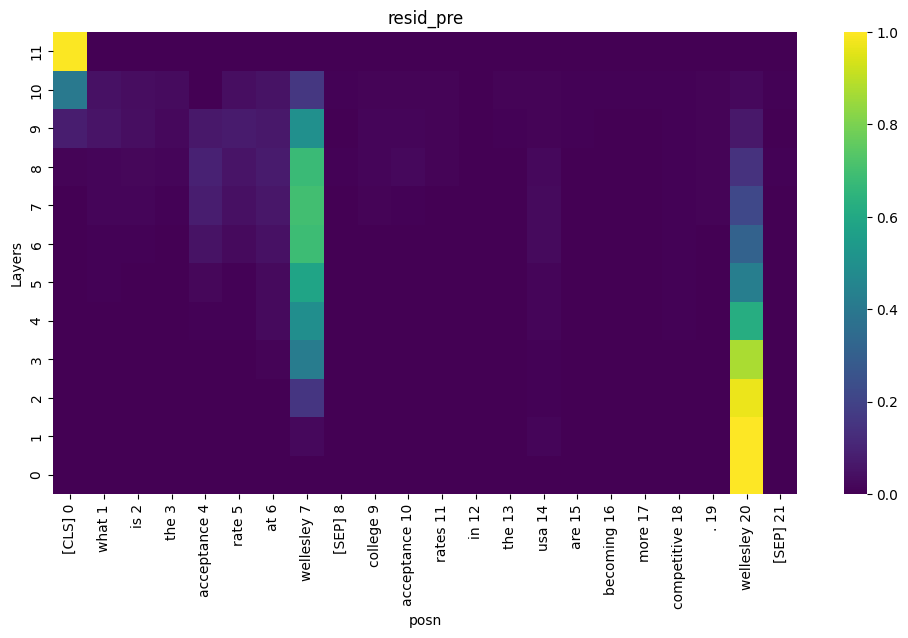

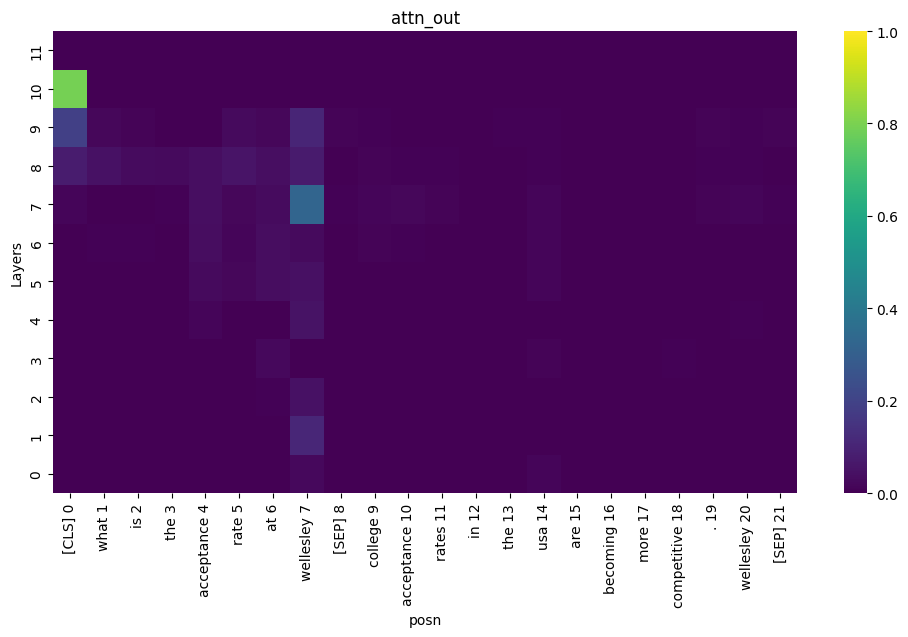

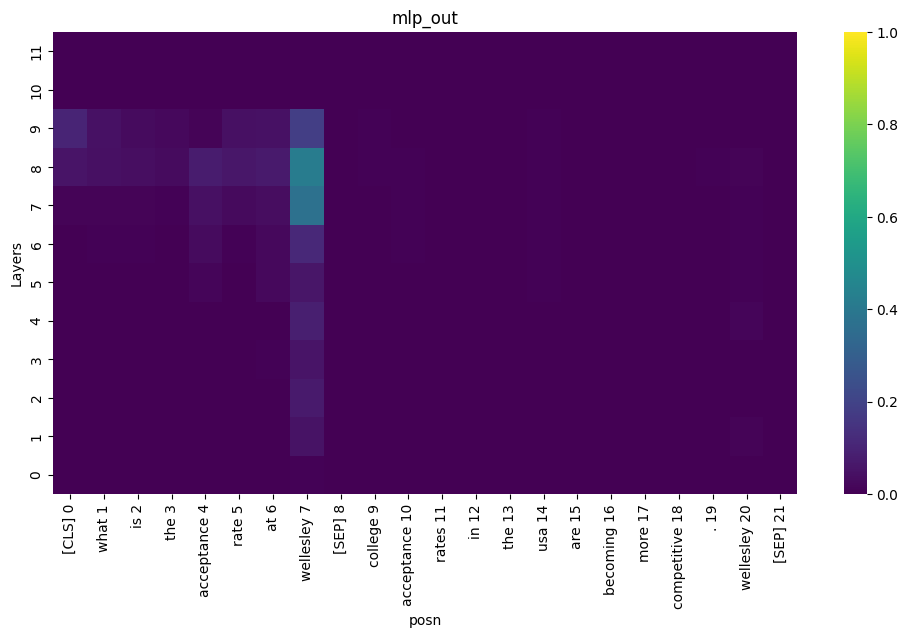

In [17]:
       
# Activation patching - by block over all token positions (e.g., input to residual stream, activation block output, MLP output)

tokens = [tokenizer.decode(tok) for tok in tokenized_pair_perturbed["input_ids"][0]]
labels = [f"{tok} {i}" for i, tok in enumerate(tokens)]
act_patch_block_every = get_act_patch_block_every(
    tl_model,
    device,
    tokenized_pair_baseline,
    perturbed_cache,
    ranking_metric,
    pooler_layer,
    dropout_layer,
    classifier_layer
)
detached_block_results = act_patch_block_every.detach().cpu().numpy()
plot_heatmap_block(detached_block_results, labels) #3，12，34


Patching: attn_heads


100%|██████████| 12/12 [00:27<00:00,  2.29s/it]

(12, 12)


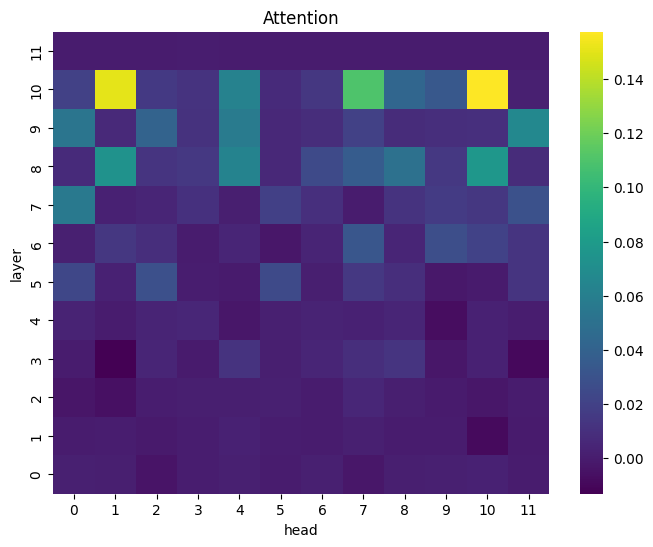

In [18]:

# Activation patching - by attention head over all token positions
act_patch_attn_head_out_all_pos = get_act_patch_attn_head_out_all_pos(
    tl_model,
    device,
    tokenized_pair_baseline,
    perturbed_cache,
    ranking_metric,
    pooler_layer,
    dropout_layer,
    classifier_layer
)
detached_head_results = act_patch_attn_head_out_all_pos.detach().cpu().numpy()
plot_heatmap_attention(detached_head_results, labels)




Example Demo for Path-Patching

In [ ]:

path_patch_head_to_final_resid_post = get_path_patch_head_to_final_resid_post(
                                                tl_model, 
                                                device,
                                                ranking_metric,
                                                tokenized_pair_perturbed,
                                                tokenized_pair_baseline,
                                                perturbed_cache,
                                                baseline_cache,
                                                pooler_layer,
                                                dropout_layer,
                                                classifier_layer)
path_patch_head_to_heads = get_path_patch_head_to_heads([(10,1)],#the specific head to path patch to
                                                        'k',#: str, either k, q or v, patching to which vector
                                                        tl_model,#: HookedTransformer,
                                                        device,
                                                        ranking_metric,
                                                        tokenized_pair_perturbed,
                                                        tokenized_pair_baseline,
                                                        perturbed_cache,
                                                        baseline_cache,
                                                        pooler_layer,
                                                        dropout_layer,
                                                        classifier_layer
                                                    )


detached_path_patch_tofinal_results =path_patch_head_to_final_resid_post.detach().cpu().numpy()
detached_path_patch_head_to_heads = path_patch_head_to_heads.detach().cpu().numpy()






<function get_path_patch_head_to_final_resid_post.<locals>.<lambda> at 0x3ba5c0940>


100%|██████████| 144/144 [00:27<00:00,  5.26it/s]


<function get_path_patch_head_to_heads.<locals>.<lambda> at 0x3ba5c01f0>


  0%|          | 0/120 [00:00<?, ?it/s]

tensor([[-5.6513]], device='mps:0')


  1%|          | 1/120 [00:00<00:47,  2.52it/s]

tensor([[-5.6514]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


  2%|▏         | 2/120 [00:00<00:45,  2.58it/s]

tensor([[-5.6517]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


  2%|▎         | 3/120 [00:01<00:45,  2.59it/s]

tensor([[-5.6513]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


  3%|▎         | 4/120 [00:01<00:44,  2.61it/s]

tensor([[-5.6513]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


  4%|▍         | 5/120 [00:01<00:43,  2.63it/s]

tensor([[-5.6513]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


  5%|▌         | 6/120 [00:02<00:43,  2.63it/s]

tensor([[-5.6513]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


  6%|▌         | 7/120 [00:02<00:42,  2.64it/s]

tensor([[-5.6511]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


  7%|▋         | 8/120 [00:03<00:42,  2.65it/s]

tensor([[-5.6506]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


  8%|▊         | 9/120 [00:03<00:42,  2.64it/s]

tensor([[-5.6563]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


  8%|▊         | 10/120 [00:03<00:41,  2.64it/s]

tensor([[-5.6513]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


  9%|▉         | 11/120 [00:04<00:41,  2.65it/s]

tensor([[-5.6515]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


 10%|█         | 12/120 [00:04<00:40,  2.64it/s]

tensor([[-5.6508]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


 11%|█         | 13/120 [00:04<00:40,  2.63it/s]

tensor([[-5.6516]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


 12%|█▏        | 14/120 [00:05<00:40,  2.64it/s]

tensor([[-5.6518]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


 12%|█▎        | 15/120 [00:05<00:39,  2.63it/s]

tensor([[-5.6527]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


 13%|█▎        | 16/120 [00:06<00:39,  2.63it/s]

tensor([[-5.6514]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


 14%|█▍        | 17/120 [00:06<00:39,  2.63it/s]

tensor([[-5.6561]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


 15%|█▌        | 18/120 [00:06<00:38,  2.62it/s]

tensor([[-5.6514]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


 16%|█▌        | 19/120 [00:07<00:38,  2.63it/s]

tensor([[-5.6513]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


 17%|█▋        | 20/120 [00:07<00:37,  2.65it/s]

tensor([[-5.7493]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


 18%|█▊        | 21/120 [00:07<00:37,  2.65it/s]

tensor([[-5.6510]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


 18%|█▊        | 22/120 [00:08<00:36,  2.67it/s]

tensor([[-5.6513]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


 19%|█▉        | 23/120 [00:08<00:36,  2.67it/s]

tensor([[-5.6520]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


 20%|██        | 24/120 [00:09<00:35,  2.67it/s]

tensor([[-5.6513]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


 21%|██        | 25/120 [00:09<00:35,  2.67it/s]

tensor([[-5.6513]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


 22%|██▏       | 26/120 [00:09<00:35,  2.67it/s]

tensor([[-5.6701]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


 22%|██▎       | 27/120 [00:10<00:34,  2.66it/s]

tensor([[-5.6516]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


 23%|██▎       | 28/120 [00:10<00:34,  2.67it/s]

tensor([[-5.6508]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


 24%|██▍       | 29/120 [00:10<00:34,  2.67it/s]

tensor([[-5.6512]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


 25%|██▌       | 30/120 [00:11<00:33,  2.68it/s]

tensor([[-5.6504]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


 26%|██▌       | 31/120 [00:11<00:33,  2.69it/s]

tensor([[-5.6513]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


 27%|██▋       | 32/120 [00:12<00:32,  2.69it/s]

tensor([[-5.6513]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


 28%|██▊       | 33/120 [00:12<00:32,  2.70it/s]

tensor([[-5.6512]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


 28%|██▊       | 34/120 [00:12<00:31,  2.70it/s]

tensor([[-5.6513]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


 29%|██▉       | 35/120 [00:13<00:31,  2.71it/s]

tensor([[-5.6524]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


 30%|███       | 36/120 [00:13<00:31,  2.70it/s]

tensor([[-5.6513]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


 31%|███       | 37/120 [00:13<00:30,  2.70it/s]

tensor([[-5.6492]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


 32%|███▏      | 38/120 [00:14<00:30,  2.67it/s]

tensor([[-5.6544]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


 32%|███▎      | 39/120 [00:14<00:30,  2.68it/s]

tensor([[-5.6513]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


 33%|███▎      | 40/120 [00:15<00:29,  2.68it/s]

tensor([[-5.6513]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


 34%|███▍      | 41/120 [00:15<00:29,  2.69it/s]

tensor([[-5.6496]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


 35%|███▌      | 42/120 [00:15<00:29,  2.69it/s]

tensor([[-5.6520]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


 36%|███▌      | 43/120 [00:16<00:28,  2.68it/s]

tensor([[-5.6507]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


 37%|███▋      | 44/120 [00:16<00:28,  2.68it/s]

tensor([[-5.6513]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


 38%|███▊      | 45/120 [00:16<00:28,  2.68it/s]

tensor([[-5.6499]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


 38%|███▊      | 46/120 [00:17<00:27,  2.68it/s]

tensor([[-5.6512]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


 39%|███▉      | 47/120 [00:17<00:27,  2.68it/s]

tensor([[-5.6512]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


 40%|████      | 48/120 [00:18<00:26,  2.68it/s]

tensor([[-5.6498]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


 41%|████      | 49/120 [00:18<00:26,  2.66it/s]

tensor([[-5.6493]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


 42%|████▏     | 50/120 [00:18<00:26,  2.67it/s]

tensor([[-5.6520]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


 42%|████▎     | 51/120 [00:19<00:25,  2.66it/s]

tensor([[-5.6486]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


 43%|████▎     | 52/120 [00:19<00:25,  2.67it/s]

tensor([[-5.6483]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


 44%|████▍     | 53/120 [00:19<00:25,  2.67it/s]

tensor([[-5.6509]], device='mps:0')
tensor([[-5.6514]], device='mps:0')


 45%|████▌     | 54/120 [00:20<00:24,  2.68it/s]

tensor([[-5.6519]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


 46%|████▌     | 55/120 [00:20<00:24,  2.69it/s]

tensor([[-5.6449]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


 47%|████▋     | 56/120 [00:21<00:23,  2.69it/s]

tensor([[-5.6499]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


 48%|████▊     | 57/120 [00:21<00:23,  2.69it/s]

tensor([[-5.6467]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


 48%|████▊     | 58/120 [00:21<00:22,  2.70it/s]

tensor([[-5.6641]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


 49%|████▉     | 59/120 [00:22<00:22,  2.68it/s]

tensor([[-5.6486]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


 50%|█████     | 60/120 [00:22<00:22,  2.69it/s]

tensor([[-5.6507]], device='mps:0')
tensor([[-5.6515]], device='mps:0')


 51%|█████     | 61/120 [00:22<00:21,  2.69it/s]

tensor([[-5.6456]], device='mps:0')
tensor([[-5.6514]], device='mps:0')


 52%|█████▏    | 62/120 [00:23<00:21,  2.69it/s]

tensor([[-5.6501]], device='mps:0')
tensor([[-5.6525]], device='mps:0')


 52%|█████▎    | 63/120 [00:23<00:21,  2.69it/s]

tensor([[-5.6315]], device='mps:0')
tensor([[-5.6514]], device='mps:0')


 53%|█████▎    | 64/120 [00:23<00:20,  2.70it/s]

tensor([[-5.6499]], device='mps:0')
tensor([[-5.6515]], device='mps:0')


 54%|█████▍    | 65/120 [00:24<00:20,  2.70it/s]

tensor([[-5.6486]], device='mps:0')
tensor([[-5.6513]], device='mps:0')


 55%|█████▌    | 66/120 [00:24<00:19,  2.70it/s]

tensor([[-5.6514]], device='mps:0')
tensor([[-5.6515]], device='mps:0')


 56%|█████▌    | 67/120 [00:25<00:19,  2.71it/s]

tensor([[-5.6523]], device='mps:0')
tensor([[-5.6515]], device='mps:0')


 57%|█████▋    | 68/120 [00:25<00:19,  2.71it/s]

tensor([[-5.6614]], device='mps:0')
tensor([[-5.6519]], device='mps:0')


 57%|█████▊    | 69/120 [00:25<00:18,  2.70it/s]

tensor([[-5.6510]], device='mps:0')
tensor([[-5.6512]], device='mps:0')


 58%|█████▊    | 70/120 [00:26<00:18,  2.70it/s]

tensor([[-5.6563]], device='mps:0')
tensor([[-5.6519]], device='mps:0')


 59%|█████▉    | 71/120 [00:26<00:18,  2.71it/s]

tensor([[-5.6505]], device='mps:0')
tensor([[-5.6522]], device='mps:0')


 60%|██████    | 72/120 [00:26<00:17,  2.70it/s]

tensor([[-5.6488]], device='mps:0')
tensor([[-5.6501]], device='mps:0')


 61%|██████    | 73/120 [00:27<00:17,  2.72it/s]

tensor([[-5.6494]], device='mps:0')
tensor([[-5.6532]], device='mps:0')


 62%|██████▏   | 74/120 [00:27<00:17,  2.70it/s]

tensor([[-5.6521]], device='mps:0')
tensor([[-5.6509]], device='mps:0')


 62%|██████▎   | 75/120 [00:28<00:16,  2.71it/s]

tensor([[-5.6422]], device='mps:0')
tensor([[-5.6591]], device='mps:0')


 63%|██████▎   | 76/120 [00:28<00:16,  2.70it/s]

tensor([[-5.6576]], device='mps:0')
tensor([[-5.6486]], device='mps:0')


 64%|██████▍   | 77/120 [00:28<00:15,  2.70it/s]

tensor([[-5.6522]], device='mps:0')
tensor([[-5.6532]], device='mps:0')


 65%|██████▌   | 78/120 [00:29<00:15,  2.70it/s]

tensor([[-5.6748]], device='mps:0')
tensor([[-5.6481]], device='mps:0')


 66%|██████▌   | 79/120 [00:29<00:15,  2.70it/s]

tensor([[-5.6487]], device='mps:0')
tensor([[-5.6575]], device='mps:0')


 67%|██████▋   | 80/120 [00:29<00:14,  2.71it/s]

tensor([[-5.6404]], device='mps:0')
tensor([[-5.6512]], device='mps:0')


 68%|██████▊   | 81/120 [00:30<00:14,  2.71it/s]

tensor([[-5.6481]], device='mps:0')
tensor([[-5.6538]], device='mps:0')


 68%|██████▊   | 82/120 [00:30<00:14,  2.71it/s]

tensor([[-5.6453]], device='mps:0')
tensor([[-5.6503]], device='mps:0')


 69%|██████▉   | 83/120 [00:31<00:13,  2.72it/s]

tensor([[-5.6410]], device='mps:0')
tensor([[-5.6369]], device='mps:0')


 70%|███████   | 84/120 [00:31<00:13,  2.72it/s]

tensor([[-5.6496]], device='mps:0')
tensor([[-5.6545]], device='mps:0')


 71%|███████   | 85/120 [00:31<00:12,  2.71it/s]

tensor([[-5.6111]], device='mps:0')
tensor([[-5.6457]], device='mps:0')


 72%|███████▏  | 86/120 [00:32<00:12,  2.70it/s]

tensor([[-5.6639]], device='mps:0')
tensor([[-5.6466]], device='mps:0')


 72%|███████▎  | 87/120 [00:32<00:12,  2.68it/s]

tensor([[-5.6457]], device='mps:0')
tensor([[-5.6528]], device='mps:0')


 73%|███████▎  | 88/120 [00:32<00:11,  2.68it/s]

tensor([[-5.6523]], device='mps:0')
tensor([[-5.6408]], device='mps:0')


 74%|███████▍  | 89/120 [00:33<00:11,  2.70it/s]

tensor([[-5.6449]], device='mps:0')
tensor([[-5.6567]], device='mps:0')


 75%|███████▌  | 90/120 [00:33<00:11,  2.69it/s]

tensor([[-5.6485]], device='mps:0')
tensor([[-5.6517]], device='mps:0')


 76%|███████▌  | 91/120 [00:33<00:10,  2.68it/s]

tensor([[-5.6545]], device='mps:0')
tensor([[-5.6497]], device='mps:0')


 77%|███████▋  | 92/120 [00:34<00:10,  2.68it/s]

tensor([[-5.6548]], device='mps:0')
tensor([[-5.6415]], device='mps:0')


 78%|███████▊  | 93/120 [00:34<00:10,  2.69it/s]

tensor([[-5.6518]], device='mps:0')
tensor([[-5.6109]], device='mps:0')


 78%|███████▊  | 94/120 [00:35<00:09,  2.69it/s]

tensor([[-5.7678]], device='mps:0')
tensor([[-5.6502]], device='mps:0')


 79%|███████▉  | 95/120 [00:35<00:09,  2.69it/s]

tensor([[-5.6550]], device='mps:0')
tensor([[-5.6464]], device='mps:0')


 80%|████████  | 96/120 [00:35<00:08,  2.69it/s]

tensor([[-5.6421]], device='mps:0')
tensor([[-5.5140]], device='mps:0')


 81%|████████  | 97/120 [00:36<00:08,  2.69it/s]

tensor([[-5.6388]], device='mps:0')
tensor([[-5.6189]], device='mps:0')


 82%|████████▏ | 98/120 [00:36<00:08,  2.69it/s]

tensor([[-5.6511]], device='mps:0')
tensor([[-5.6316]], device='mps:0')


 82%|████████▎ | 99/120 [00:36<00:07,  2.70it/s]

tensor([[-5.6485]], device='mps:0')
tensor([[-5.6418]], device='mps:0')


 83%|████████▎ | 100/120 [00:37<00:07,  2.70it/s]

tensor([[-5.6497]], device='mps:0')
tensor([[-5.6173]], device='mps:0')


 84%|████████▍ | 101/120 [00:37<00:07,  2.71it/s]

tensor([[-5.6526]], device='mps:0')
tensor([[-5.5866]], device='mps:0')


 85%|████████▌ | 102/120 [00:38<00:06,  2.71it/s]

tensor([[-5.7109]], device='mps:0')
tensor([[-5.5827]], device='mps:0')


 86%|████████▌ | 103/120 [00:38<00:06,  2.71it/s]

tensor([[-5.6460]], device='mps:0')
tensor([[-5.5897]], device='mps:0')


 87%|████████▋ | 104/120 [00:38<00:05,  2.70it/s]

tensor([[-5.6253]], device='mps:0')
tensor([[-5.4176]], device='mps:0')


 88%|████████▊ | 105/120 [00:39<00:05,  2.71it/s]

tensor([[-5.6635]], device='mps:0')
tensor([[-5.6142]], device='mps:0')


 88%|████████▊ | 106/120 [00:39<00:05,  2.71it/s]

tensor([[-5.6274]], device='mps:0')
tensor([[-5.6653]], device='mps:0')


 89%|████████▉ | 107/120 [00:39<00:04,  2.69it/s]

tensor([[-5.6388]], device='mps:0')
tensor([[-5.6514]], device='mps:0')


 90%|█████████ | 108/120 [00:40<00:04,  2.72it/s]

tensor([[-5.6343]], device='mps:0')
tensor([[-5.4151]], device='mps:0')


 91%|█████████ | 109/120 [00:40<00:04,  2.71it/s]

tensor([[-5.6691]], device='mps:0')
tensor([[-5.5877]], device='mps:0')


 92%|█████████▏| 110/120 [00:41<00:03,  2.70it/s]

tensor([[-5.6669]], device='mps:0')
tensor([[-5.5253]], device='mps:0')


 92%|█████████▎| 111/120 [00:41<00:03,  2.69it/s]

tensor([[-5.6352]], device='mps:0')
tensor([[-5.5996]], device='mps:0')


 93%|█████████▎| 112/120 [00:41<00:02,  2.69it/s]

tensor([[-5.6799]], device='mps:0')
tensor([[-5.3700]], device='mps:0')


 94%|█████████▍| 113/120 [00:42<00:02,  2.67it/s]

tensor([[-5.6939]], device='mps:0')
tensor([[-5.5784]], device='mps:0')


 95%|█████████▌| 114/120 [00:42<00:02,  2.69it/s]

tensor([[-5.6549]], device='mps:0')
tensor([[-5.6278]], device='mps:0')


 96%|█████████▌| 115/120 [00:42<00:01,  2.69it/s]

tensor([[-5.6588]], device='mps:0')
tensor([[-5.5823]], device='mps:0')


 97%|█████████▋| 116/120 [00:43<00:01,  2.69it/s]

tensor([[-5.6723]], device='mps:0')
tensor([[-5.6002]], device='mps:0')


 98%|█████████▊| 117/120 [00:43<00:01,  2.70it/s]

tensor([[-5.6612]], device='mps:0')
tensor([[-5.6240]], device='mps:0')


 98%|█████████▊| 118/120 [00:44<00:00,  2.68it/s]

tensor([[-5.6610]], device='mps:0')
tensor([[-5.6072]], device='mps:0')


 99%|█████████▉| 119/120 [00:44<00:00,  2.68it/s]

tensor([[-5.6462]], device='mps:0')
tensor([[-5.6138]], device='mps:0')


100%|██████████| 120/120 [00:44<00:00,  2.68it/s]

tensor([[-5.7616]], device='mps:0')


In [21]:
print(detached_path_patch_tofinal_results.shape)
print(detached_path_patch_head_to_heads.shape)

(12, 12)
(10, 12)


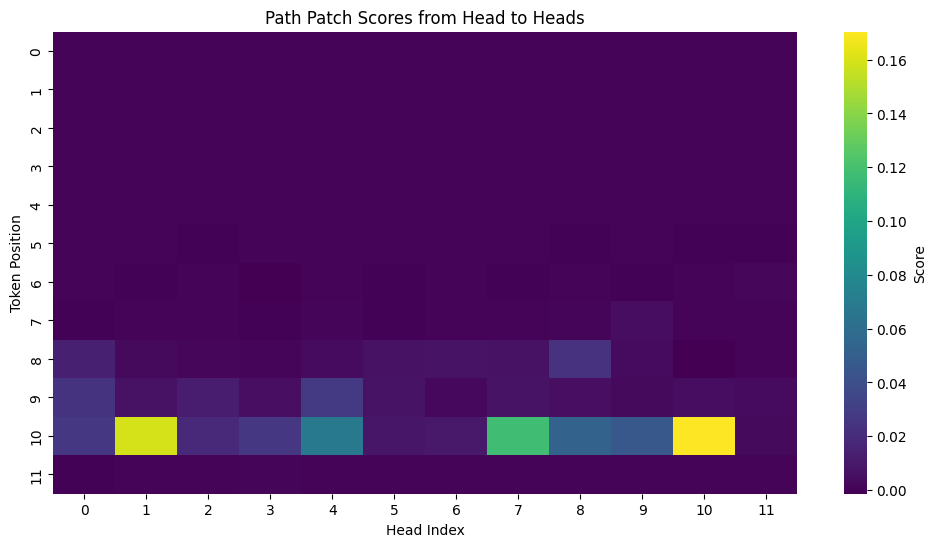

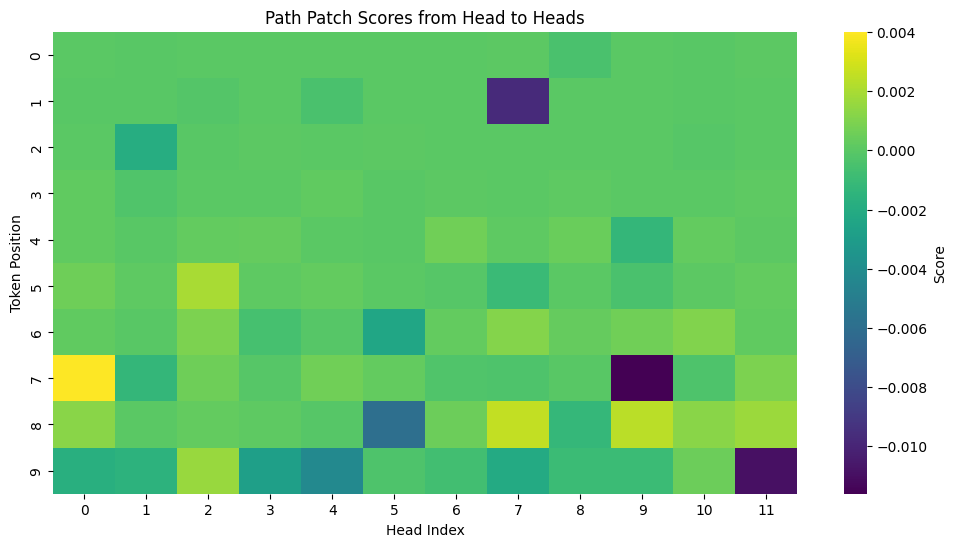

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


result1 = detached_path_patch_tofinal_results  # shape (12, 12)
result2 = detached_path_patch_head_to_heads    # shape (10, 12)


plt.figure(figsize=(12, 6))
sns.heatmap(result1, cmap="viridis", cbar_kws={'label': 'Score'})
plt.title("Path Patch Scores from Head to Heads")
plt.xlabel("Head Index")
plt.ylabel("Token Position")
plt.show()

# Plot 2: Heatmap for result2 (already 2D)
plt.figure(figsize=(12, 6))
sns.heatmap(result2, cmap="viridis", cbar_kws={'label': 'Score'})
plt.title("Path Patch Scores from Head to Heads")
plt.xlabel("Head Index")
plt.ylabel("Token Position")
plt.show()
